<a href="https://colab.research.google.com/github/david3951445/ML_project/blob/main/FinalProject/project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir data # 建立資料夾

import numpy as np
from numpy.core.numeric import NaN
import pandas as pd
from pandas.core.frame import DataFrame
import os 

from datetime import datetime
from pandas.core.reshape.concat import concat

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

import scipy.stats as st
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LSTM
from keras import optimizers
from keras.optimizers import Adam
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

import xgboost as xgb
from sklearn.model_selection import GridSearchCV


# ignore warning : This TensorFlow binary is optimized with oneAPI ...
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def main():
    ''' load data '''

    data_report = pd.read_csv('data/report.csv', low_memory=False)
    data_submission = pd.read_csv('data/submission.csv')
    data_birth = pd.read_csv('data/birth.csv')
    # data_breed = pd.read_csv('data/breed.csv')
    # data_spec = pd.read_csv('data/spec.csv')
    
    '''
    # Data pre-processing #
    important data : season of calv-ing,  氣候,  泌乳高峰第幾天 , stocking  rate
    一開始的六個星期中奶量不斷提高，一直到每日25至60升，然後不斷下降
    
    brith.csv
    COL 2, 3 :
        COL 2 - COL 3(前一胎次) = 乾乳期
    COL 4, 5 : 犢牛1, 犢牛2
        insufficient, drop()
    COL 6 : 母牛體重
    COL 7, 9 : 登錄日期, 胎次 
        repeat, drop()
    COL 8 : 計算胎次
        meaningless, drop()
    COL 10 : 分娩難易度
    COL 11, 12: 犢牛體型, 犢牛性 
        insufficient, drop()
    COL 13 : 酪農場代號
        repeat, drop()
    
    bread.csv
    report.csv
    COL 2 : 年
        drop
    COL 3 : 月
    x_train.replace([3, 4, 5], 'spring')
    x_train.replace([6, 7, 8], 'summer')
    x_train.replace([9, 10, 11], 'autumn') 
    x_train.replace([12, 1, 2], 'winter')
    COL 4 : 農場代號
    COL 5 : 乳牛編號
    COL 6, 7 : 父、母
        drop()
    COL 8 : 出生日期
        drop()
    COL 9 : 胎次
        反比
    COL 10 : 泌乳天數 (COL 15 - COL 12)
    COL 11 : 乳量
    COL 12 : 最近分娩
        if 19 has value
            分娩間隔 = COL 12 - COL 19
        else
            分娩間隔 = COL 12 - COL 8 # 第一次分娩 - 出生日期
    COL 13 : 採樣日期 (COL 15 - (1day ~ 3day))
        drop()
    COL 14 : 月齡
        反比
    COL 15 : 檢測日期 (年/月 : COL 2 / COL 3)
        drop()
    COL 16 : 最後配種日期 (=受精)
    COL 17 : 最後配種精液
    COL 18 : 配種次數
        反比
    COL 19 : 前次分娩日期
        drop()
    COL 20 : 第一次配種日期
    COL 21 : 第一次配種精液
    spec.csv (health)
 
    '''

    # # construct train data
    x_train = pd.DataFrame()

    # # COL 3
    temp = data_report.iloc[:, 2]
    temp = temp.replace([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2], ['spring', 'spring', 'spring',\
                                          'summer', 'summer', 'summer',\
                                          'autumn', 'autumn', 'autumn',\
                                          'winter', 'winter', 'winter'])
    #temp.replace([3, 4, 5], 'spring')
    #temp.replace([4, 5, 6], 'summer')
    #temp.replace([5, 6, 7], 'autumn') 
    #temp.replace([6, 1, 2], 'winter')
    x_train = pd.concat([x_train, temp], axis=1) # axis=1 means colume

    # # COL 4, 9, 10, 11, 14, 18
    x_train = pd.concat([x_train, data_report['4']], axis=1)
    x_train = pd.concat([x_train, data_report['9']], axis=1)
    x_train = pd.concat([x_train, data_report['10']], axis=1)
    x_train = pd.concat([x_train, data_report['11']], axis=1) # y_train
    x_train = pd.concat([x_train, data_report['14']], axis=1)
    x_train = pd.concat([x_train, data_report['18']], axis=1)

    # # birth_interval
    temp1 = data_report['12'].copy()
    temp2 = data_report['19'].copy()
    i1 = np.where(temp1.isna())[0]
    i2 = np.where(temp2.isna())[0]

    # 補缺項
    temp1.iloc[i1] = temp1.iloc[i1[0] + 1] , # temporary method
    temp2.iloc[i2] = data_report.iloc[i2, 7] # 第一次分娩 - 出生日期

    birth_interval = day_interval(temp1, temp2, 'birth_interval')
    x_train = pd.concat([x_train, birth_interval], axis=1)

    # # # dry_interval
    # # 先透過 data_birth 計算乾乳期
    data_birth_copy = data_birth.copy() # copy
    data_birth_copy = data_birth_copy.sort_values(by=['1', '9']) # sort 牛編號, 胎次
    i_cow_b = ~data_birth_copy.duplicated(subset=['1']) # find all cow

    temp = data_birth_copy.iloc[:, 2].shift() # 原資料的乾乳時間是下個胎次的
    temp.loc[i_cow_b] = NaN # teporary method, 第一胎次乾乳期 = NaN
    dry_interval = day_interval(data_birth_copy.iloc[:, 1], temp, 'dry_interval')
 
    # 補缺項
    data_birth_copy = pd.concat([data_birth_copy, dry_interval, pd.DataFrame(i_cow_b, columns=['i_cow_b'])], axis=1)  
    index = [a or b for a, b in zip(data_birth_copy['dry_interval'] < 0, data_birth_copy['dry_interval'] > 5*30)]
    data_birth_copy = data_birth_copy.drop(data_birth_copy.loc[index].index) # 不合理的值直接排除 (保留 0~150天)
    mean = np.mean(data_birth_copy['dry_interval'])
    temp_cow_dry = data_birth_copy.fillna(mean) # teporary method, NaN(第一胎次乾乳期) = 平均值

    # # 把 birth 的資料融入 report
    # 索引操作
    data_report_copy = data_report.copy()
    data_report_copy = data_report_copy.sort_values(by=['5', '9']) # sort 牛編號, 胎次
    i_cd_b = temp_cow_dry.set_index(keys = ['1', '9']) # 將牛編號, 胎次轉為 index
    i_cd_b = i_cd_b.drop(i_cd_b.columns.drop(['dry_interval']), axis=1) # 保留 index, dry_interval
    i_cd_r = data_report_copy.set_index(keys = ['5', '9']) # 將牛編號, 胎次轉為 index
    i_cd_r = i_cd_r.drop(i_cd_r.columns, axis=1) # 保留 index 就好
    
    # 補缺項
    for a, b in i_cd_b.index :
        try :
            i_cd_r.loc[(a, b), 'dry_interval'] = i_cd_b.loc[(a, b), 'dry_interval'].iloc[0]
        except :
            continue # 如果birth有report沒有的牛，跳過 (經測試，只有一隻)
    i_cd_r['dry_interval'] = i_cd_r['dry_interval'].fillna(mean) # teporary method, 如果report有birth沒有的牛 乾乳期 = 平均值

    # 塞進 x_train
    array = i_cd_r.to_numpy()
    temp = pd.DataFrame(array, columns=['dry_interval'])
    temp.loc[data_report_copy.index.values, ['dry_interval']] = array
    x_train = pd.concat([x_train, temp], axis=1)

    # # one hot
    x_train = pd.get_dummies(x_train)
    
    # # split x_test from x_train
    index = np.where(x_train['11'].isna())[0]
    temp = x_train.loc[index]

    x_train = x_train.drop(index) # train input data 
    x_train = x_train.dropna() # 保證最後不會有 NaN
    y_train = x_train.pop('11') # train output data
    x_test = temp.drop(['11'], axis=1) # test input data
    print(x_train.shape) 
    print(y_train.shape)
    print(x_test.shape) 
    # x_train.to_csv('test.csv')

    ''' ML model training '''
    # 打在這
    data_number = len(x_train.iloc[:, 0])
    feature_number = len(x_train.iloc[0, :])

    test_number = len(x_test.iloc[:, 0])

    '''scikit learn
    model = DecisionTreeRegressor()  # 選擇Model
    model.fit(x_train, y_train)  # 訓練
    y_predictions = model.predict(x_test)  # 預測
    '''

    # 誤差計算
    def rmse(y_pred,y_true):
      return K.sqrt(K.mean(K.square(y_pred-y_true)))

    # NN
    
    # 建立Sequential
    neurons=256
    model=Sequential()
    model.add(Dense(neurons, input_dim=feature_number, bias_initializer='normal', activation='relu'))
    model.add(Dense(neurons, bias_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1), bias_initializer='normal')
    
    # 編譯(損失函數,評估標準:RMSE 優化器:adam.adamax)
    model.compile(loss=rmse,optimizer="adam",metrics=[rmse])
    #model.compile(loss=rmse,optimizer='Adamax',metrics=[rmse])
    #model.compile(loss=rmse,optimizer='Nadam',metrics=[rmse])
    #neurons=[64, 128, 256]
    #param_grid = dict(neurons=neurons)
    #model=GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=3, verbose=True)

    # 訓練
    model = KerasRegressor(build_fn=model, epochs=100, batch_size=128, verbose=1)
    model.fit(x_train,y_train)
    
    '''
    # xgboost model
    xgboost = xgb.XGBRegressor()
    param_grid = [
    {'nthread': [4], 'objective':['reg:squarederror'], 'learning_rate':[0.05, 0.08, 0.1],
     'max_depth': [4, 5, 6], 'min_child_weight': [3, 4], 'silent': [1], 'subsample': [0.7],
     'colsample_bytree': [0.7], 'n_estimators': [150, 300, 500]}]
    model = GridSearchCV(xgboost, param_grid, cv=2, n_jobs=10, verbose=True)
    model.fit(x_train,y_train) # 訓練
    '''

    ''' ML model pridict '''
    # # input x_test, output y_predict
    # y_predict = model.predict(x_test)
    # data_submission['1'] = y_predict
    # data_submission.to_csv('out.csv', index=False)
    y_predict = model.predict(x_test)  # 預測
    data_submission['1'] = y_predict
    data_submission.to_csv('out.csv', index=False)

# day intervel of two Series with string type
def day_interval(temp1, temp2, name) :
    date1 = pd.to_datetime(temp1)
    date2 = pd.to_datetime(temp2)
    #date1 = [datetime.strptime(i, "%Y/%m/%d %H:%M") for i in temp1]
    return pd.DataFrame([(a - b).days for a, b in zip(date1, date2)], columns=[name], index=temp1.index) # preserver temp1.index

if __name__ == '__main__':
    main()

In [6]:
import numpy as np
from numpy.core.numeric import NaN
import pandas as pd
from pandas.core.frame import DataFrame
import os 

from datetime import datetime
from pandas.core.reshape.concat import concat

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

import scipy.stats as st
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras import optimizers
from keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras import layers


# ignore warning : This TensorFlow binary is optimized with oneAPI ...
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def main():
    ''' load data '''

    data_report = pd.read_csv('data/report.csv', low_memory=False)
    data_submission = pd.read_csv('data/submission.csv')
    data_birth = pd.read_csv('data/birth.csv')
    # data_breed = pd.read_csv('data/breed.csv')
    # data_spec = pd.read_csv('data/spec.csv')
    
    '''
    # Data pre-processing #
    important data : season of calv-ing,  氣候,  泌乳高峰第幾天 , stocking  rate
    一開始的六個星期中奶量不斷提高，一直到每日25至60升，然後不斷下降
    
    brith.csv
    COL 2, 3 :
        COL 2 - COL 3(前一胎次) = 乾乳期
    COL 4, 5 : 犢牛1, 犢牛2
        insufficient, drop()
    COL 6 : 母牛體重
    COL 7, 9 : 登錄日期, 胎次 
        repeat, drop()
    COL 8 : 計算胎次
        meaningless, drop()
    COL 10 : 分娩難易度
    COL 11, 12: 犢牛體型, 犢牛性 
        insufficient, drop()
    COL 13 : 酪農場代號
        repeat, drop()
    
    bread.csv
    report.csv
    COL 2 : 年
        drop
    COL 3 : 月
    x_train.replace([3, 4, 5], 'spring')
    x_train.replace([6, 7, 8], 'summer')
    x_train.replace([9, 10, 11], 'autumn') 
    x_train.replace([12, 1, 2], 'winter')
    COL 4 : 農場代號
    COL 5 : 乳牛編號
    COL 6, 7 : 父、母
        drop()
    COL 8 : 出生日期
        drop()
    COL 9 : 胎次
        反比
    COL 10 : 泌乳天數 (COL 15 - COL 12)
    COL 11 : 乳量
    COL 12 : 最近分娩
        if 19 has value
            分娩間隔 = COL 12 - COL 19
        else
            分娩間隔 = COL 12 - COL 8 # 第一次分娩 - 出生日期
    COL 13 : 採樣日期 (COL 15 - (1day ~ 3day))
        drop()
    COL 14 : 月齡
        反比
    COL 15 : 檢測日期 (年/月 : COL 2 / COL 3)
        drop()
    COL 16 : 最後配種日期 (=受精)
    COL 17 : 最後配種精液
    COL 18 : 配種次數
        反比
    COL 19 : 前次分娩日期
        drop()
    COL 20 : 第一次配種日期
    COL 21 : 第一次配種精液
    spec.csv (health)
 
    '''

    # # construct train data
    x_train = pd.DataFrame()

    # # COL 3
    temp = data_report.iloc[:, 2]
    temp = temp.replace([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2], ['spring', 'spring', 'spring',\
                                          'summer', 'summer', 'summer',\
                                          'autumn', 'autumn', 'autumn',\
                                          'winter', 'winter', 'winter'])
    #temp.replace([3, 4, 5], 'spring')
    #temp.replace([4, 5, 6], 'summer')
    #temp.replace([5, 6, 7], 'autumn') 
    #temp.replace([6, 1, 2], 'winter')
    x_train = pd.concat([x_train, temp], axis=1) # axis=1 means colume

    # # COL 4, 9, 10, 11, 14, 18
    x_train = pd.concat([x_train, data_report['4']], axis=1)
    x_train = pd.concat([x_train, data_report['9']], axis=1)
    x_train = pd.concat([x_train, data_report['10']], axis=1)
    x_train = pd.concat([x_train, data_report['11']], axis=1) # y_train
    x_train = pd.concat([x_train, data_report['14']], axis=1)
    x_train = pd.concat([x_train, data_report['18']], axis=1)

    # # birth_interval
    temp1 = data_report['12'].copy()
    temp2 = data_report['19'].copy()
    i1 = np.where(temp1.isna())[0]
    i2 = np.where(temp2.isna())[0]

    # 補缺項
    temp1.iloc[i1] = temp1.iloc[i1[0] + 1] , # temporary method
    temp2.iloc[i2] = data_report.iloc[i2, 7] # 第一次分娩 - 出生日期

    birth_interval = day_interval(temp1, temp2, 'birth_interval')
    x_train = pd.concat([x_train, birth_interval], axis=1)

    # # # dry_interval
    # # 先透過 data_birth 計算乾乳期
    data_birth_copy = data_birth.copy() # copy
    data_birth_copy = data_birth_copy.sort_values(by=['1', '9']) # sort 牛編號, 胎次
    i_cow_b = ~data_birth_copy.duplicated(subset=['1']) # find all cow

    temp = data_birth_copy.iloc[:, 2].shift() # 原資料的乾乳時間是下個胎次的
    temp.loc[i_cow_b] = NaN # teporary method, 第一胎次乾乳期 = NaN
    dry_interval = day_interval(data_birth_copy.iloc[:, 1], temp, 'dry_interval')
 
    # 補缺項
    data_birth_copy = pd.concat([data_birth_copy, dry_interval, pd.DataFrame(i_cow_b, columns=['i_cow_b'])], axis=1)  
    index = [a or b for a, b in zip(data_birth_copy['dry_interval'] < 0, data_birth_copy['dry_interval'] > 5*30)]
    data_birth_copy = data_birth_copy.drop(data_birth_copy.loc[index].index) # 不合理的值直接排除 (保留 0~150天)
    mean = np.mean(data_birth_copy['dry_interval'])
    temp_cow_dry = data_birth_copy.fillna(mean) # teporary method, NaN(第一胎次乾乳期) = 平均值

    # # 把 birth 的資料融入 report
    # 索引操作
    data_report_copy = data_report.copy()
    data_report_copy = data_report_copy.sort_values(by=['5', '9']) # sort 牛編號, 胎次
    i_cd_b = temp_cow_dry.set_index(keys = ['1', '9']) # 將牛編號, 胎次轉為 index
    i_cd_b = i_cd_b.drop(i_cd_b.columns.drop(['dry_interval']), axis=1) # 保留 index, dry_interval
    i_cd_r = data_report_copy.set_index(keys = ['5', '9']) # 將牛編號, 胎次轉為 index
    i_cd_r = i_cd_r.drop(i_cd_r.columns, axis=1) # 保留 index 就好
    
    # 補缺項
    for a, b in i_cd_b.index :
        try :
            i_cd_r.loc[(a, b), 'dry_interval'] = i_cd_b.loc[(a, b), 'dry_interval'].iloc[0]
        except :
            continue # 如果birth有report沒有的牛，跳過 (經測試，只有一隻)
    i_cd_r['dry_interval'] = i_cd_r['dry_interval'].fillna(mean) # teporary method, 如果report有birth沒有的牛 乾乳期 = 平均值

    # 塞進 x_train
    array = i_cd_r.to_numpy()
    temp = pd.DataFrame(array, columns=['dry_interval'])
    temp.loc[data_report_copy.index.values, ['dry_interval']] = array
    x_train = pd.concat([x_train, temp], axis=1)

    # # one hot
    x_train = pd.get_dummies(x_train)
    
    # # split x_test from x_train
    index = np.where(x_train['11'].isna())[0]
    temp = x_train.loc[index]

    x_train = x_train.drop(index) # train input data 
    x_train = x_train.dropna() # 保證最後不會有 NaN
    y_train = x_train.pop('11') # train output data
    x_test = temp.drop(['11'], axis=1) # test input data
    print(x_train.shape) 
    print(y_train.shape)
    print(x_test.shape) 
    # x_train.to_csv('test.csv')

    ''' ML model training '''
    # 打在這
    data_number = len(x_train.iloc[:, 0])
    feature_number = len(x_train.iloc[0, :])

    test_number = len(x_test.iloc[:, 0])

    '''scikit learn
    model = DecisionTreeRegressor()  # 選擇Model
    model.fit(x_train, y_train)  # 訓練
    y_predictions = model.predict(x_test)  # 預測
    '''

    # NN
    y_predict = NN(x_train, y_train, x_test, feature_number, dimension=128, drop=0.1, epoch=80, batch=256)
    data_submission['1'] = y_predict
    data_submission.to_csv('out.csv', index=False)

# day intervel of two Series with string type
def day_interval(temp1, temp2, name) :
    date1 = pd.to_datetime(temp1)
    date2 = pd.to_datetime(temp2)
    #date1 = [datetime.strptime(i, "%Y/%m/%d %H:%M") for i in temp1]
    return pd.DataFrame([(a - b).days for a, b in zip(date1, date2)], columns=[name], index=temp1.index) # preserver temp1.index

# Neural Network
def NN(train_data, train_target, test_data, feature_n, dimension, drop, epoch, batch):
    # 建立Sequential
    model=Sequential()
    model.add(Dense(dimension,input_dim=feature_n,activation='relu'))
    model.add(Dense(dimension,activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(dimension,activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(1))

    # 編譯(損失函數,評估標準:RMSE 優化器:adam.adamax)
    model.compile(loss=rmse,optimizer="adam",metrics=[rmse])
    #model.compile(loss=rmse,optimizer='Adamax',metrics=[rmse])
    #model.compile(loss=rmse,optimizer='Nadam',metrics=[rmse])

    # 訓練
    model.fit(train_data,train_target,epochs=epoch,batch_size=batch,verbose=1)


    ''' ML model pridict '''
    # # input x_test, output y_predict
    # y_predict = model.predict(x_test)
    # data_submission['1'] = y_predict
    # data_submission.to_csv('out.csv', index=False)
    y_predict = model.predict(test_data)  # 預測
    return y_predict

# 誤差計算
def rmse(y_pred,y_true):
    return K.sqrt(K.mean(K.square(y_pred-y_true)))

if __name__ == '__main__':
    main()

(33253, 13)
(33253,)
(4263, 13)
Epoch 1/80
130/130 [==============================] - 18s 6ms/step - loss: 23.8978 - rmse: 23.8977
Epoch 2/80
130/130 [==============================] - 1s 6ms/step - loss: 8.8846 - rmse: 8.8846
Epoch 3/80
130/130 [==============================] - 1s 7ms/step - loss: 8.4289 - rmse: 8.4289
Epoch 4/80
130/130 [==============================] - 1s 6ms/step - loss: 8.0061 - rmse: 8.0062
Epoch 5/80
130/130 [==============================] - 1s 6ms/step - loss: 7.7010 - rmse: 7.7010
Epoch 6/80
130/130 [==============================] - 1s 6ms/step - loss: 7.3957 - rmse: 7.3957
Epoch 7/80
130/130 [==============================] - 1s 6ms/step - loss: 7.3143 - rmse: 7.3143
Epoch 8/80
130/130 [==============================] - 1s 6ms/step - loss: 7.1878 - rmse: 7.1878
Epoch 9/80
130/130 [==============================] - 1s 6ms/step - loss: 7.2149 - rmse: 7.2149
Epoch 10/80
130/130 [==============================] - 1s 6ms/step - loss: 7.1976 - rmse: 7.1976
Epoc

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of   8 | elapsed:   15.0s remaining:   15.0s
[Parallel(n_jobs=10)]: Done   8 out of   8 | elapsed:   20.9s finished


Best Params:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 0, 'subsample': 0.7}


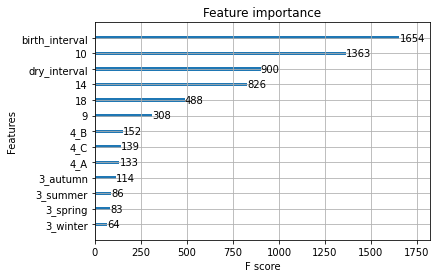

In [3]:
import numpy as np
from numpy.core.numeric import NaN
import pandas as pd
from pandas.core.frame import DataFrame
import os 

from datetime import datetime
from pandas.core.reshape.concat import concat

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import scipy.stats as st
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras import optimizers
from keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras import layers

from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt

# ignore warning : This TensorFlow binary is optimized with oneAPI ...
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def main():
    ''' load data '''
    data_report = pd.read_csv('data/report.csv')
    data_submission = pd.read_csv('data/submission.csv')
    data_birth = pd.read_csv('data/birth.csv')
    # data_breed = pd.read_csv('data/breed.csv')
    # data_spec = pd.read_csv('data/spec.csv')
    
    '''
    # Data pre-processing #
    important data : season of calving,  氣候,  泌乳高峰第幾天(dry interval) , stocking  rate
    一開始的六個星期中奶量不斷提高，一直到每日25至60升，然後不斷下降
    
    brith.csv
    COL 2, 3 :
        COL 2 - COL 3(前一胎次) = 乾乳期
    COL 4, 5 : 犢牛1, 犢牛2
        insufficient, drop()
    COL 6 : 母牛體重
    COL 7, 9 : 登錄日期, 胎次 
        repeat, drop()
    COL 8 : 計算胎次
        meaningless, drop()
    COL 10 : 分娩難易度
    COL 11, 12: 犢牛體型, 犢牛性 
        insufficient, drop()
    COL 13 : 酪農場代號
        repeat, drop()
    
    bread.csv
    report.csv
    COL 2 : 年
        drop()
    COL 3 : 月
    x_train.replace([3, 4, 5], 'spring')
    x_train.replace([6, 7, 8], 'summer')
    x_train.replace([9, 10, 11], 'autumn') 
    x_train.replace([12, 1, 2], 'winter')
    COL 4 : 農場代號
    COL 5 : 乳牛編號
    COL 6, 7 : 父、母
        drop()
    COL 8 : 出生日期
        drop()
    COL 9 : 胎次
        反比
    COL 10 : 泌乳天數 (COL 15 - COL 12)
    COL 11 : 乳量
    COL 12 : 最近分娩
        if 19 has value
            分娩間隔 = COL 12 - COL 19
        else
            分娩間隔 = COL 12 - COL 8 # 第一次分娩 - 出生日期
    COL 13 : 採樣日期 (COL 15 - (1day ~ 3day))
        drop()
    COL 14 : 月齡
        反比
    COL 15 : 檢測日期 (年/月 : COL 2 / COL 3)
        drop()
    COL 16 : 最後配種日期 (=受精)
    COL 17 : 最後配種精液
    COL 18 : 配種次數
        反比
    COL 19 : 前次分娩日期
        drop()
    COL 20 : 第一次配種日期
    COL 21 : 第一次配種精液
    spec.csv (health)
 
    '''
    x_train = pd.DataFrame()

    # # COL 3
    temp = data_report.iloc[:, 2]
    temp = temp.replace([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2], ['spring', 'spring', 'spring',\
                                          'summer', 'summer', 'summer',\
                                          'autumn', 'autumn', 'autumn',\
                                          'winter', 'winter', 'winter'])
    x_train = pd.concat([x_train, temp], axis=1) # axis=1 means colume

    # # COL 4, 9, 10, 11, 14, 18
    x_train = pd.concat([x_train, data_report['4']], axis=1) # 農場代號
    x_train = pd.concat([x_train, data_report['9']], axis=1) # 胎次
    x_train = pd.concat([x_train, data_report['10']], axis=1) # 泌乳天數
    x_train = pd.concat([x_train, data_report['11']], axis=1) # y_train
    x_train = pd.concat([x_train, data_report['14']], axis=1) # 月齡
    x_train = pd.concat([x_train, data_report['18']], axis=1) # 配種次數

    # # birth_interval
    temp1 = data_report['12'].copy()
    temp2 = data_report['19'].copy()
    i1 = np.where(temp1.isna())[0]
    i2 = np.where(temp2.isna())[0]

    # 補缺項
    temp1.iloc[i1] = temp1.iloc[i1[0] + 1] , # temporary method
    temp2.iloc[i2] = data_report.iloc[i2, 7] # 第一次分娩 - 出生日期

    birth_interval = day_interval(temp1, temp2, 'birth_interval')
    x_train = pd.concat([x_train, birth_interval], axis=1)


    # # # dry_interval
    # # 先透過 data_birth 計算乾乳期
    data_birth_copy = data_birth.copy() # copy
    data_birth_copy = data_birth_copy.sort_values(by=['1', '9']) # sort 牛編號, 胎次
    i_cow_b = ~data_birth_copy.duplicated(subset=['1']) # find all cow

    temp = data_birth_copy.iloc[:, 2].shift() # 原資料的乾乳時間是下個胎次的
    temp.loc[i_cow_b] = NaN # teporary method, 第一胎次乾乳期 = NaN
    dry_interval = day_interval(data_birth_copy.iloc[:, 1], temp, 'dry_interval')
 
    # 補缺項
    data_birth_copy = pd.concat([data_birth_copy, dry_interval, pd.DataFrame(i_cow_b, columns=['i_cow_b'])], axis=1)  
    index = [a or b for a, b in zip(data_birth_copy['dry_interval'] < 0, data_birth_copy['dry_interval'] > 5*30)]
    data_birth_copy = data_birth_copy.drop(data_birth_copy.loc[index].index) # 不合理的值直接排除 (保留 0~150天)
    mean = np.mean(data_birth_copy['dry_interval'])
    temp_cow_dry = data_birth_copy.fillna(mean) # teporary method, NaN(第一胎次乾乳期) = 平均值


    # # 把 birth 的資料放入 report
    # 索引操作
    data_report_copy = data_report.copy()
    data_report_copy = data_report_copy.sort_values(by=['5', '9']) # sort 牛編號, 胎次
    i_cd_b = temp_cow_dry.set_index(keys = ['1', '9']) # 將牛編號, 胎次轉為 index
    i_cd_b = i_cd_b.drop(i_cd_b.columns.drop(['dry_interval']), axis=1) # 保留 index, dry_interval
    i_cd_r = data_report_copy.set_index(keys = ['5', '9']) # 將牛編號, 胎次轉為 index
    i_cd_r = i_cd_r.drop(i_cd_r.columns, axis=1) # 保留 index 就好
    
    # 補缺項
    for a, b in i_cd_b.index :
        try :
            i_cd_r.loc[(a, b), 'dry_interval'] = i_cd_b.loc[(a, b), 'dry_interval'].iloc[0]
        except :
            continue # 如果birth有report沒有的牛，跳過 (經測試，只有一隻)
    i_cd_r['dry_interval'] = i_cd_r['dry_interval'].fillna(mean) # teporary method, 如果report有birth沒有的牛 乾乳期 = 平均值

    # 塞進 x_train
    array = i_cd_r.to_numpy()
    temp = pd.DataFrame(array, columns=['dry_interval'])
    temp.loc[data_report_copy.index.values, ['dry_interval']] = array
    x_train = pd.concat([x_train, temp], axis=1)


    ''' one hot '''
    x_train = pd.get_dummies(x_train)

    ''' split x_train into x_train, x_test, y_train '''
    index = np.where(x_train['11'].isna())[0]
    temp = x_train.loc[index]

    x_train = x_train.drop(index) # train input data 
    x_train = x_train.dropna() # 保證最後不會有 NaN
    y_train = x_train.pop('11') # train output data
    x_test = temp.drop(['11'], axis=1) # test input data

    ''' normalize '''
    scale = StandardScaler() #z-scaler物件
    x_train = pd.DataFrame(scale.fit_transform(x_train), columns=x_train.keys())
    x_test = pd.DataFrame(scale.fit_transform(x_test), columns=x_test.keys())

    # print(x_train) 
    # print(y_train.shape)
    # print(x_test) 

    ''' ML model training '''
    # 打在這
    data_number = len(x_train.iloc[:, 0])
    feature_number = len(x_train.iloc[0, :])

    test_number = len(x_test.iloc[:, 0])

    '''scikit learn
    y_pridict = scikit(x_train, y_train, x_test)
    '''

    '''NN
    # 誤差計算
    def rmse(y_pred,y_true):
      return K.sqrt(K.mean(K.square(y_pred-y_true)))

    # 建立Sequential
    model=Sequential()
    model.add(Dense(256,input_dim=feature_number,activation='relu'))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    # 編譯(損失函數,評估標準:RMSE 優化器:adam.adamax)
    #model.compile(loss=rmse,optimizer="adam",metrics=[rmse])
    #model.compile(loss=rmse,optimizer='Adamax',metrics=[rmse])
    model.compile(loss=rmse,optimizer='Nadam',metrics=[rmse])

    # 訓練
    model.fit(x_train,y_train,epochs=10,batch_size=256,verbose=1)
    '''
    # model
    y_predict = xgboost_reg(x_train, y_train, x_test, data_number)
    xgboost_ori(x_train, y_train)
    data_submission['1'] = y_predict
    data_submission.to_csv('out.csv', index=False)


# day intervel of two Series with string type
def day_interval(temp1, temp2, name) :
    date1 = pd.to_datetime(temp1)
    date2 = pd.to_datetime(temp2)
    #date1 = [datetime.strptime(i, "%Y/%m/%d %H:%M") for i in temp1]
    return pd.DataFrame([(a - b).days for a, b in zip(date1, date2)], columns=[name], index=temp1.index) # preserver temp1.index

def normalize(df, cols):
    """Normalize a dataframe with specified columns
    Keyword arguments:
    df -- the input dataframe (pandas.DataFrame)
    cols -- the specified columns to be normalized (list)
    """
    train_set_normalized = df.copy()
    for col in cols:
        all_col_data = train_set_normalized[col].copy()
        # print(all_col_data)
        mu = all_col_data.mean()
        std = all_col_data.std()
        
        z_score_normalized = (all_col_data - mu) / std
        train_set_normalized[col] = z_score_normalized
    return train_set_normalized

def scikit(train_data, train_target, test_data):
    model = DecisionTreeRegressor()  # 選擇Model
    model.fit(train_data, train_target)  # 訓練
    y_predictions = model.predict(test_data)  # 預測
    return y_pridictions

def xgboost_reg(train_data, train_target, test_data, data_number):
    xgboost = xgb.XGBRegressor()
    param = [{'nthread': [4], 'objective':['reg:squarederror'],
    'learning_rate':[0.1],'max_depth': [4, 5],'min_child_weight': [4],
    'silent': [0], 'subsample': [0.7],'colsample_bytree': [0.7],
    'n_estimators': [100, 300]}]
    model = GridSearchCV(xgboost, param, cv=2, n_jobs=10, verbose=2)
    model.fit(train_data,train_target) # 訓練
    print('Best Params:')
    print(model.best_params_)
   
    ''' ML model pridict '''
    # # input x_test, output y_predict
    # y_predict = model.predict(x_test)
    # data_submission['1'] = y_predict
    # data_submission.to_csv('out.csv', index=False)
    y_predict = model.predict(test_data)  # 預測
    return y_predict

def xgboost_ori(train_data, train_target):
    params = {
    'booster': 'gbtree',
    'objective': 'reg:gamma',
    'gamma': 0.1,
    'max_depth': 5,
    'lambda': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
    }

    dtrain = xgb.DMatrix(train_data, train_target)
    num_rounds = 300
    plst = params.items()
    model = xgb.train(plst, dtrain, num_rounds)

    plot_importance(model)
    plt.show()

    '''
    # 对测试集进行预测
    dtest = xgb.DMatrix(test_data)
    y_predict = model.predict(dtest)
    return y_predict
    '''



if __name__ == '__main__':
    main()

# debug
# df2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]), columns=['a', 'b', 'c'])
# print(df2)
# f = pd.Series([0, 2])
# df2.iloc[f, [0, 2]] = [[10, 10], [10, 10]]
# print(df2)

In [ ]:
# scikit-learn
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# 測試檔案
data_train = pd.read_csv('test/Training_set.csv', header=None).to_numpy()
data_test = pd.read_csv('test/Validation_set.csv', header=None).to_numpy()

train_array = data_train
data_number = len(train_array[:, 0])
feature_number = len(train_array[0, :])-1
x_train = train_array[:, :feature_number]
y_train = train_array[:, feature_number]

test_array = data_test
test_number = len(test_array[:, 0])
x_test = test_array[:, :feature_number]
y_test = test_array[:, feature_number]

model = KNeighborsRegressor()  # 選擇Model
model.fit(x_train, y_train)  # 訓練
y_predictions = model.predict(x_test)  # 預測

print("prediction:", y_predictions)
print("true values:", y_test)


prediction: [0.57  0.848 0.704 0.686 0.95  0.662 0.674 0.82  0.828 0.858 0.64  0.804
 0.564 0.648 0.708 0.622 0.74  0.668 0.93  0.726 0.416 0.762 0.66  0.858
 0.936 0.942 0.71  0.734 0.626 0.674 0.736 0.81  0.702 0.69  0.476 0.952
 0.918 0.798 0.646 0.822 0.642 0.814 0.622 0.626 0.704 0.78  0.836 0.714
 0.482 0.704 0.72  0.61  0.756 0.776 0.672 0.936 0.938 0.482 0.92  0.834
 0.922 0.88  0.626 0.94  0.93  0.872 0.676 0.662 0.832 0.688 0.614 0.69
 0.478 0.628 0.644 0.828 0.652 0.64  0.894 0.708 0.81  0.88  0.64  0.624
 0.636 0.79  0.62  0.888 0.784 0.838 0.664 0.71  0.904 0.7   0.74  0.94
 0.588 0.636 0.718 0.82 ]
true values: [0.56 0.85 0.63 0.66 0.96 0.46 0.66 0.81 0.73 0.8  0.62 0.79 0.59 0.49
 0.49 0.67 0.76 0.7  0.94 0.73 0.34 0.74 0.66 0.79 0.91 0.94 0.64 0.73
 0.71 0.81 0.67 0.85 0.8  0.73 0.64 0.89 0.9  0.88 0.69 0.72 0.56 0.86
 0.69 0.48 0.77 0.78 0.92 0.8  0.54 0.75 0.83 0.73 0.81 0.52 0.71 0.92
 0.94 0.59 0.93 0.89 0.9  0.86 0.79 0.93 0.87 0.91 0.61 0.71 0.82 0.62
 0.68 0.64 0

In [ ]:
# Keras Sequential 
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras import optimizers
from keras.optimizers import Adam
from keras import backend as K

# 測試資料
data_train = pd.read_csv('test/Training_set.csv', header=None).to_numpy()
data_test = pd.read_csv('test/Validation_set.csv', header=None).to_numpy()

train_array = data_train
data_number = len(train_array[:, 0])
feature_number = len(train_array[0, :])-1
x_train = train_array[:, :feature_number]
y_train = train_array[:, feature_number]

test_array = data_test
test_number = len(test_array[:, 0])
x_test = test_array[:, :feature_number]
y_test = test_array[:, feature_number]

# 誤差計算
def rmse(y_pred,y_true):
    return K.sqrt(K.mean(K.square(y_pred-y_true)))

# 建立Sequential
model=Sequential()
model.add(Dense(256,input_dim=3,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.08))
model.add(Dense(1))

# 編譯(損失函數,評估標準:RMSE 優化器:adam.adamax)
#model.compile(loss=rmse,optimizer="adam",metrics=[rmse])
model.compile(loss=rmse,optimizer='Adamax',metrics=[rmse])

# 訓練
model.fit(x_train,y_train,epochs=200,batch_size=64)

# 預測
y_predictions=model.predict(x_test)

print("prediction:", y_predictions)
print("true values:", y_test)



Epoch 1/200
5/5 [==============================] - 1s 4ms/step - loss: 19.0197 - rmse: 18.9213
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 15.2561 - rmse: 15.2510
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 10.5350 - rmse: 10.5212
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 7.6429 - rmse: 7.6796
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 6.8540 - rmse: 6.8423
Epoch 6/200
5/5 [==============================] - 0s 5ms/step - loss: 6.3780 - rmse: 6.3703
Epoch 7/200
5/5 [==============================] - 0s 4ms/step - loss: 5.8629 - rmse: 5.8583
Epoch 8/200
5/5 [==============================] - 0s 4ms/step - loss: 5.8786 - rmse: 5.8911
Epoch 9/200
5/5 [==============================] - 0s 4ms/step - loss: 6.2146 - rmse: 6.2181
Epoch 10/200
5/5 [==============================] - 0s 4ms/step - loss: 5.3569 - rmse: 5.3506
Epoch 11/200
5/5 [==============================] - 0s 5ms/step

In [ ]:
# xgboost
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# 測試檔案
data_train = pd.read_csv('test/Training_set.csv', header=None).to_numpy()
data_test = pd.read_csv('test/Validation_set.csv', header=None).to_numpy()

train_array = data_train
data_number = len(train_array[:, 0])
feature_number = len(train_array[0, :])-1
x_train = train_array[:, :feature_number]
y_train = train_array[:, feature_number]

test_array = data_test
test_number = len(test_array[:, 0])
x_test = test_array[:, :feature_number]
y_test = test_array[:, feature_number]

# xgboost model
model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='reg:gamma')
model.fit(x_train,y_train) # 訓練

y_predictions = model.predict(x_test)  # 預測

print("prediction:", y_predictions)
print("true values:", y_test)


prediction: [0.5709306  0.8351755  0.70201826 0.6911322  0.96599716 0.7858964
 0.6373249  0.8277904  0.80317855 0.7976576  0.7251878  0.7776781
 0.57484615 0.6988175  0.74707496 0.63468206 0.7941694  0.65663046
 0.91994554 0.7113621  0.43061587 0.7608472  0.7268247  0.8029149
 0.92513216 0.9475089  0.7413105  0.7163768  0.58394164 0.64377785
 0.7289882  0.8069674  0.7289882  0.65723336 0.58043885 0.9634623
 0.9105843  0.8162116  0.5980303  0.8079289  0.7059652  0.7527299
 0.6303393  0.68979484 0.7259644  0.7148053  0.8311399  0.7028618
 0.50037354 0.6924369  0.7494806  0.6127671  0.6917654  0.76573235
 0.6944614  0.94026005 0.9056089  0.383981   0.8910601  0.86239535
 0.9134456  0.8643629  0.6157113  0.942719   0.91472447 0.9110675
 0.7407952  0.69480336 0.81844103 0.74840564 0.67167646 0.7048507
 0.4756728  0.6363284  0.6593508  0.84696376 0.60374427 0.6628752
 0.93887573 0.73014146 0.8069674  0.8643629  0.6025801  0.6529295
 0.6525026  0.775861   0.5527689  0.87952244 0.8046529  0.76

In [ ]:
import numpy as np
x=[[1,2,0],
  [2,3,4],
   [0,1,4],
   [1,2,1]]
y=np.max(x,axis=0)
#z=y+10
z=x-y
print(x)
print(y)
print(z)

[[1, 2, 0], [2, 3, 4], [0, 1, 4], [1, 2, 1]]
[2 3 4]
[[-1 -1 -4]
 [ 0  0  0]
 [-2 -2  0]
 [-1 -1 -3]]
